##### This noteboos is based on:
-  [Roberta Strikes Back !](https://www.kaggle.com/code/theoviel/roberta-strikes-back) 
-  [Pytorch Bert baseline to RoBERTa NBME
](https://www.kaggle.com/code/iamsdt/pytorch-bert-baseline-to-roberta-nbme)
-  [【Train】Deberta-v3-large baseline
](https://www.kaggle.com/code/librauee/train-deberta-v3-large-baseline)


##### Apply trained model from this book can get 0.876 LB. I know in Roberta Strikes Back ! the author use Roberta-large get 0.882, hope someone can use it to get higher LB.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import subprocess
from sklearn.preprocessing import  LabelEncoder

if not os.path.isdir("./Data"):
    env = os.environ.copy()
    subprocess.run(
        'ln -s "/content/drive/My Drive/CMU/Spring2022/AI_for_Social_Good/Project/Data" /content/Data',
        shell=True,
        env=env,
    )

In [3]:
%pip install transformers

     |████████████████████████████████| 4.0 MB 7.3 MB/s 
     |████████████████████████████████| 77 kB 7.8 MB/s 
     |████████████████████████████████| 880 kB 76.9 MB/s 
     |████████████████████████████████| 6.6 MB 63.0 MB/s 
     |████████████████████████████████| 596 kB 85.2 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=34a08e143e4a0da982c639a2442ab96a0477c1fd07748db9c72a9f27e47893d8
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
ROOT = "../content/Data"

# Library

In [5]:
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import string
import pickle
import random
import joblib
import itertools
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn import metrics, model_selection
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Config

In [6]:
config = dict(
    seed = 2020,
    num_labels=2,
    num_folds=1,
    fold_to_train = [0],
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    model_checkpoint = 'roberta-large', 
    learning_rate = 1e-5,
    weight_decay = 1e-2,
    max_length = 512,
    train_batch_size = 2,
    valid_batch_size = 2,
    epochs_to_train = 1,
    total_epochs = 1,
    grad_acc_steps = 4,
    num_cycles=0.5,
    scheduler='linear', # ['linear', 'cosine']
    output_dir = '/content/drive/My Drive/CMU/Spring2022/AI_for_Social_Good/Project/Output',
    debug = None,
    precompute_tokens = True
)

# Data Loading

In [7]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(f"{ROOT}/train.csv")

# train['annotation'] = train['annotation'].apply(ast.literal_eval)
train['location'] = train['location'].apply(ast.literal_eval)
features = pd.read_csv(f"{ROOT}/features.csv")
def preprocess_features(features):
    features.loc[27, 'feature_text'] = "Last-Pap-smear-1-year-ago"
    return features
features = preprocess_features(features)
patient_notes = pd.read_csv(f"{ROOT}/patient_notes.csv")

print(f"train.shape: {train.shape}")
display(train.head())
print(f"features.shape: {features.shape}")
display(features.head())
print(f"patient_notes.shape: {patient_notes.shape}")
display(patient_notes.head())

train.shape: (14300, 6)


,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],[696 724]
1,00016_001,0,16,1,"['mom with ""thyroid disease']",[668 693]
2,00016_002,0,16,2,['chest pressure'],[203 217]
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","[70 91, 176 183]"
4,00016_004,0,16,4,['felt as if he were going to pass out'],[222 258]


features.shape: (143, 3)


,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


patient_notes.shape: (42146, 3)


,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


In [8]:
def process_feature_text(text):
    text = re.sub('I-year', '1-year', text)
    text = re.sub('-OR-', " or ", text)
    text = re.sub('-', ' ', text)
    return text


def clean_spaces(txt):
    txt = re.sub('\n', ' ', txt)
    txt = re.sub('\t', ' ', txt)
    txt = re.sub('\r', ' ', txt)
#     txt = re.sub(r'\s+', ' ', txt)
    return txt

In [9]:
train = train.merge(features, on=['feature_num', 'case_num'], how='left')
train = train.merge(patient_notes, on=['pn_num', 'case_num'], how='left')
train['pn_history'] = train['pn_history'].apply(lambda x: x.strip())
train['feature_text'] = train['feature_text'].apply(process_feature_text)

train['feature_text'] = train['feature_text'].apply(clean_spaces)
train['clean_text'] = train['pn_history'].apply(clean_spaces)


display(train.head())

,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history,clean_text
0,00016_000,0,16,0,['dad with recent heart attcak'],[696 724],Family history of MI or Family history of myoc...,HPI: 17yo M presents with palpitations. Patien...,HPI: 17yo M presents with palpitations. Patien...
1,00016_001,0,16,1,"['mom with ""thyroid disease']",[668 693],Family history of thyroid disorder,HPI: 17yo M presents with palpitations. Patien...,HPI: 17yo M presents with palpitations. Patien...
2,00016_002,0,16,2,['chest pressure'],[203 217],Chest pressure,HPI: 17yo M presents with palpitations. Patien...,HPI: 17yo M presents with palpitations. Patien...
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","[70 91, 176 183]",Intermittent symptoms,HPI: 17yo M presents with palpitations. Patien...,HPI: 17yo M presents with palpitations. Patien...
4,00016_004,0,16,4,['felt as if he were going to pass out'],[222 258],Lightheaded,HPI: 17yo M presents with palpitations. Patien...,HPI: 17yo M presents with palpitations. Patien...


In [10]:
# incorrect annotation
train.loc[338, 'annotation'] = ast.literal_eval('[["father heart attack"]]')
train.loc[338, 'location'] = ast.literal_eval('[["764 783"]]')

train.loc[621, 'annotation'] = ast.literal_eval('[["for the last 2-3 months"]]')
train.loc[621, 'location'] = ast.literal_eval('[["77 100"]]')

train.loc[655, 'annotation'] = ast.literal_eval('[["no heat intolerance"], ["no cold intolerance"]]')
train.loc[655, 'location'] = ast.literal_eval('[["285 292;301 312"], ["285 287;296 312"]]')

train.loc[1262, 'annotation'] = ast.literal_eval('[["mother thyroid problem"]]')
train.loc[1262, 'location'] = ast.literal_eval('[["551 557;565 580"]]')

train.loc[1265, 'annotation'] = ast.literal_eval('[[\'felt like he was going to "pass out"\']]')
train.loc[1265, 'location'] = ast.literal_eval('[["131 135;181 212"]]')

train.loc[1396, 'annotation'] = ast.literal_eval('[["stool , with no blood"]]')
train.loc[1396, 'location'] = ast.literal_eval('[["259 280"]]')

train.loc[1591, 'annotation'] = ast.literal_eval('[["diarrhoe non blooody"]]')
train.loc[1591, 'location'] = ast.literal_eval('[["176 184;201 212"]]')

train.loc[1615, 'annotation'] = ast.literal_eval('[["diarrhea for last 2-3 days"]]')
train.loc[1615, 'location'] = ast.literal_eval('[["249 257;271 288"]]')

train.loc[1664, 'annotation'] = ast.literal_eval('[["no vaginal discharge"]]')
train.loc[1664, 'location'] = ast.literal_eval('[["822 824;907 924"]]')

train.loc[1714, 'annotation'] = ast.literal_eval('[["started about 8-10 hours ago"]]')
train.loc[1714, 'location'] = ast.literal_eval('[["101 129"]]')

train.loc[1929, 'annotation'] = ast.literal_eval('[["no blood in the stool"]]')
train.loc[1929, 'location'] = ast.literal_eval('[["531 539;549 561"]]')

train.loc[2134, 'annotation'] = ast.literal_eval('[["last sexually active 9 months ago"]]')
train.loc[2134, 'location'] = ast.literal_eval('[["540 560;581 593"]]')

train.loc[2191, 'annotation'] = ast.literal_eval('[["right lower quadrant pain"]]')
train.loc[2191, 'location'] = ast.literal_eval('[["32 57"]]')

train.loc[2553, 'annotation'] = ast.literal_eval('[["diarrhoea no blood"]]')
train.loc[2553, 'location'] = ast.literal_eval('[["308 317;376 384"]]')

train.loc[3124, 'annotation'] = ast.literal_eval('[["sweating"]]')
train.loc[3124, 'location'] = ast.literal_eval('[["549 557"]]')

train.loc[3858, 'annotation'] = ast.literal_eval('[["previously as regular"], ["previously eveyr 28-29 days"], ["previously lasting 5 days"], ["previously regular flow"]]')
train.loc[3858, 'location'] = ast.literal_eval('[["102 123"], ["102 112;125 141"], ["102 112;143 157"], ["102 112;159 171"]]')

train.loc[4373, 'annotation'] = ast.literal_eval('[["for 2 months"]]')
train.loc[4373, 'location'] = ast.literal_eval('[["33 45"]]')

train.loc[4763, 'annotation'] = ast.literal_eval('[["35 year old"]]')
train.loc[4763, 'location'] = ast.literal_eval('[["5 16"]]')

train.loc[4782, 'annotation'] = ast.literal_eval('[["darker brown stools"]]')
train.loc[4782, 'location'] = ast.literal_eval('[["175 194"]]')

train.loc[4908, 'annotation'] = ast.literal_eval('[["uncle with peptic ulcer"]]')
train.loc[4908, 'location'] = ast.literal_eval('[["700 723"]]')

train.loc[6016, 'annotation'] = ast.literal_eval('[["difficulty falling asleep"]]')
train.loc[6016, 'location'] = ast.literal_eval('[["225 250"]]')

train.loc[6192, 'annotation'] = ast.literal_eval('[["helps to take care of aging mother and in-laws"]]')
train.loc[6192, 'location'] = ast.literal_eval('[["197 218;236 260"]]')

train.loc[6380, 'annotation'] = ast.literal_eval('[["No hair changes"], ["No skin changes"], ["No GI changes"], ["No palpitations"], ["No excessive sweating"]]')
train.loc[6380, 'location'] = ast.literal_eval('[["480 482;507 519"], ["480 482;499 503;512 519"], ["480 482;521 531"], ["480 482;533 545"], ["480 482;564 582"]]')

train.loc[6562, 'annotation'] = ast.literal_eval('[["stressed due to taking care of her mother"], ["stressed due to taking care of husbands parents"]]')
train.loc[6562, 'location'] = ast.literal_eval('[["290 320;327 337"], ["290 320;342 358"]]')

train.loc[6862, 'annotation'] = ast.literal_eval('[["stressor taking care of many sick family members"]]')
train.loc[6862, 'location'] = ast.literal_eval('[["288 296;324 363"]]')

train.loc[7022, 'annotation'] = ast.literal_eval('[["heart started racing and felt numbness for the 1st time in her finger tips"]]')
train.loc[7022, 'location'] = ast.literal_eval('[["108 182"]]')

train.loc[7422, 'annotation'] = ast.literal_eval('[["first started 5 yrs"]]')
train.loc[7422, 'location'] = ast.literal_eval('[["102 121"]]')

train.loc[8876, 'annotation'] = ast.literal_eval('[["No shortness of breath"]]')
train.loc[8876, 'location'] = ast.literal_eval('[["481 483;533 552"]]')

train.loc[9027, 'annotation'] = ast.literal_eval('[["recent URI"], ["nasal stuffines, rhinorrhea, for 3-4 days"]]')
train.loc[9027, 'location'] = ast.literal_eval('[["92 102"], ["123 164"]]')

train.loc[9938, 'annotation'] = ast.literal_eval('[["irregularity with her cycles"], ["heavier bleeding"], ["changes her pad every couple hours"]]')
train.loc[9938, 'location'] = ast.literal_eval('[["89 117"], ["122 138"], ["368 402"]]')

train.loc[9973, 'annotation'] = ast.literal_eval('[["gaining 10-15 lbs"]]')
train.loc[9973, 'location'] = ast.literal_eval('[["344 361"]]')

train.loc[10513, 'annotation'] = ast.literal_eval('[["weight gain"], ["gain of 10-16lbs"]]')
train.loc[10513, 'location'] = ast.literal_eval('[["600 611"], ["607 623"]]')

train.loc[11551, 'annotation'] = ast.literal_eval('[["seeing her son knows are not real"]]')
train.loc[11551, 'location'] = ast.literal_eval('[["386 400;443 461"]]')

train.loc[11677, 'annotation'] = ast.literal_eval('[["saw him once in the kitchen after he died"]]')
train.loc[11677, 'location'] = ast.literal_eval('[["160 201"]]')

train.loc[12124, 'annotation'] = ast.literal_eval('[["tried Ambien but it didnt work"]]')
train.loc[12124, 'location'] = ast.literal_eval('[["325 337;349 366"]]')

train.loc[12279, 'annotation'] = ast.literal_eval('[["heard what she described as a party later than evening these things did not actually happen"]]')
train.loc[12279, 'location'] = ast.literal_eval('[["405 459;488 524"]]')

train.loc[12289, 'annotation'] = ast.literal_eval('[["experienced seeing her son at the kitchen table these things did not actually happen"]]')
train.loc[12289, 'location'] = ast.literal_eval('[["353 400;488 524"]]')

train.loc[13238, 'annotation'] = ast.literal_eval('[["SCRACHY THROAT"], ["RUNNY NOSE"]]')
train.loc[13238, 'location'] = ast.literal_eval('[["293 307"], ["321 331"]]')

train.loc[13297, 'annotation'] = ast.literal_eval('[["without improvement when taking tylenol"], ["without improvement when taking ibuprofen"]]')
train.loc[13297, 'location'] = ast.literal_eval('[["182 221"], ["182 213;225 234"]]')

train.loc[13299, 'annotation'] = ast.literal_eval('[["yesterday"], ["yesterday"]]')
train.loc[13299, 'location'] = ast.literal_eval('[["79 88"], ["409 418"]]')

train.loc[13845, 'annotation'] = ast.literal_eval('[["headache global"], ["headache throughout her head"]]')
train.loc[13845, 'location'] = ast.literal_eval('[["86 94;230 236"], ["86 94;237 256"]]')

train.loc[14083, 'annotation'] = ast.literal_eval('[["headache generalized in her head"]]')
train.loc[14083, 'location'] = ast.literal_eval('[["56 64;156 179"]]')

In [11]:
train['annotation_length'] = train['annotation'].apply(len)
display(train['annotation_length'].value_counts())
print(train.head())

2      4407
10      582
9       543
15      530
5       518
19      384
12      329
24      314
20      312
23      299
22      294
21      293
8       260
16      256
14      249
29      232
18      231
28      230
27      226
26      224
13      198
17      193
25      187
11      169
32      160
30      151
31      134
36      128
33      107
35      105
34      102
6       102
7        97
37       95
39       93
38       87
42       77
40       65
45       63
41       62
44       57
52       54
46       52
48       51
43       50
51       44
54       43
49       40
47       37
50       35
56       32
1        31
57       29
58       28
62       23
53       23
55       22
61       21
67       21
64       19
80       18
75       17
69       17
65       17
78       17
60       16
74       16
59       16
66       14
68       14
86       14
77       14
72       13
76       11
63       11
70       11
90       10
79       10
73        9
87        9
71        8
89        8
88        8
85  

          id  case_num  pn_num  feature_num                                annotation          location                                       feature_text                                         pn_history                                         clean_text  annotation_length
0  00016_000         0      16            0          ['dad with recent heart attcak']         [696 724]  Family history of MI or Family history of myoc...  HPI: 17yo M presents with palpitations. Patien...  HPI: 17yo M presents with palpitations. Patien...                 32
1  00016_001         0      16            1             ['mom with "thyroid disease']         [668 693]                 Family history of thyroid disorder  HPI: 17yo M presents with palpitations. Patien...  HPI: 17yo M presents with palpitations. Patien...                 29
2  00016_002         0      16            2                        ['chest pressure']         [203 217]                                     Chest pressure  HPI: 17yo M pres

In [12]:
train_output = pd.read_csv(f"{ROOT}/train_output_final.csv")

In [13]:
train_output['feature_text'] = train_output['feature_text'].apply(clean_spaces)
train_output['clean_text'] = train_output['pn_history'].apply(clean_spaces)
print(train_output.head())

   Unnamed: 0  pn_num  case_num                                         pn_history  feature_num                                     feature_text         id                 location                                         clean_text
0           0   90000         9  HPI: Ms. Madden is a 20 year old previously he...          900  No-relief-with-Motrin-OR-no-relief-with-tylenol  90000_900  328 335;341 347;360 375  HPI: Ms. Madden is a 20 year old previously he...
1           1   90000         9  HPI: Ms. Madden is a 20 year old previously he...          901                                          20-year  90000_901                    23 32  HPI: Ms. Madden is a 20 year old previously he...
2           2   90000         9  HPI: Ms. Madden is a 20 year old previously he...          902                1-day-duration-OR-2-days-duration  90000_902                      NaN  HPI: Ms. Madden is a 20 year old previously he...
3           3   90000         9  HPI: Ms. Madden is a 20 year old previo

In [14]:
train_output.dropna(inplace=True)
train_output = train_output.loc[:, ~train_output.columns.str.contains('^Unnamed')]
train_output['location'] = train_output['location'].str.split(";")
print(train_output.head())

    pn_num  case_num                                         pn_history  feature_num                                     feature_text         id                     location                                         clean_text
0    90000         9  HPI: Ms. Madden is a 20 year old previously he...          900  No-relief-with-Motrin-OR-no-relief-with-tylenol  90000_900  [328 335, 341 347, 360 375]  HPI: Ms. Madden is a 20 year old previously he...
1    90000         9  HPI: Ms. Madden is a 20 year old previously he...          901                                          20-year  90000_901                      [23 32]  HPI: Ms. Madden is a 20 year old previously he...
9    90000         9  HPI: Ms. Madden is a 20 year old previously he...          909  viral-symptoms-OR-rhinorrhea-OR-scratchy-throat  90000_909           [490 497, 509 517]  HPI: Ms. Madden is a 20 year old previously he...
12   90000         9  HPI: Ms. Madden is a 20 year old previously he...          912                

In [15]:
train = pd.concat([train, train_output], axis=0)
train = pd.DataFrame(train)
train = train.loc[:, ~train.columns.str.contains('^Unnamed')]
print(train.head())

          id  case_num  pn_num  feature_num                                annotation          location                                       feature_text                                         pn_history                                         clean_text  annotation_length
0  00016_000         0      16            0          ['dad with recent heart attcak']         [696 724]  Family history of MI or Family history of myoc...  HPI: 17yo M presents with palpitations. Patien...  HPI: 17yo M presents with palpitations. Patien...               32.0
1  00016_001         0      16            1             ['mom with "thyroid disease']         [668 693]                 Family history of thyroid disorder  HPI: 17yo M presents with palpitations. Patien...  HPI: 17yo M presents with palpitations. Patien...               29.0
2  00016_002         0      16            2                        ['chest pressure']         [203 217]                                     Chest pressure  HPI: 17yo M pres

In [16]:
print(len(train))

84068


In [17]:
print(train['location'].isnull().sum())

0


In [18]:
train = train.drop(columns=['annotation','annotation_length'])

In [19]:
# train = train.drop(columns=['kfold'])
train.reset_index(drop=True)

,id,case_num,pn_num,feature_num,location,feature_text,pn_history,clean_text
0,00016_000,0,16,0,[696 724],Family history of MI or Family history of myoc...,HPI: 17yo M presents with palpitations. Patien...,HPI: 17yo M presents with palpitations. Patien...
1,00016_001,0,16,1,[668 693],Family history of thyroid disorder,HPI: 17yo M presents with palpitations. Patien...,HPI: 17yo M presents with palpitations. Patien...
2,00016_002,0,16,2,[203 217],Chest pressure,HPI: 17yo M presents with palpitations. Patien...,HPI: 17yo M presents with palpitations. Patien...
3,00016_003,0,16,3,"[70 91, 176 183]",Intermittent symptoms,HPI: 17yo M presents with palpitations. Patien...,HPI: 17yo M presents with palpitations. Patien...
4,00016_004,0,16,4,[222 258],Lightheaded,HPI: 17yo M presents with palpitations. Patien...,HPI: 17yo M presents with palpitations. Patien...
...,...,...,...,...,...,...,...,...
84063,20812_205,2,20812,205,"[90 98, 103 114]",Irregular-menses,Mrs. Montgomeery is a 44 yo caucasian female t...,Mrs. Montgomeery is a 44 yo caucasian female t...
84064,20812_206,2,20812,206,"[328 333, 352 363]",Recent-nausea-vomiting-OR-Recent-flulike-symptoms,Mrs. Montgomeery is a 44 yo caucasian female t...,Mrs. Montgomeery is a 44 yo caucasian female t...
84065,20812_211,2,20812,211,[178 186],Hot-flashes,Mrs. Montgomeery is a 44 yo caucasian female t...,Mrs. Montgomeery is a 44 yo caucasian female t...
84066,20812_212,2,20812,212,"[125 134, 139 159]",Irregular-flow-OR-Irregular-frequency-OR-Irreg...,Mrs. Montgomeery is a 44 yo caucasian female t...,Mrs. Montgomeery is a 44 yo caucasian female t...


# CV split

In [20]:
# ====================================================
# CV split
# ====================================================
Fold = GroupKFold(n_splits=5)
groups = train['pn_num'].values
print(groups)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['location'], groups)):
    # print(val_index)
    # train.loc[val_index, 'kfold'] = int(n)
    train.loc[train.index.intersection(val_index),'kfold'] = int(n)
# train['kfold'] = train['kfold'].replace(np.nan, 5.0)
# train['kfold'] = train['kfold'].astype(int)
display(train.groupby('kfold').size())

[   16    16    16 ... 20812 20812 20812]


kfold
0.0    10357
1.0    10398
2.0    10451
3.0    10373
4.0    10413
dtype: int64

# Tokenizer

In [21]:
import numpy as np
from transformers import AutoTokenizer


def get_tokenizer(name, precompute=False, df=None, folder=None):
    if folder is None:
        tokenizer = AutoTokenizer.from_pretrained(name)
    else:
        tokenizer = AutoTokenizer.from_pretrained(folder)

    tokenizer.name = name
    tokenizer.special_tokens = {
        "sep": tokenizer.sep_token_id,
        "cls": tokenizer.cls_token_id,
        "pad": tokenizer.pad_token_id,
    }

    if precompute:
        tokenizer.precomputed = precompute_tokens(df, tokenizer)
    else:
        tokenizer.precomputed = None

    return tokenizer


def precompute_tokens(df, tokenizer):
    feature_texts = df["feature_text"].unique()

    ids = {}
    offsets = {}

    for feature_text in feature_texts:
        encoding = tokenizer(
            feature_text,
            return_token_type_ids=True,
            return_offsets_mapping=True,
            return_attention_mask=False,
            add_special_tokens=False,
        )
        ids[feature_text] = encoding["input_ids"]
        offsets[feature_text] = encoding["offset_mapping"]

    texts = df["clean_text"].unique()

    for text in texts:
        encoding = tokenizer(
            text,
            return_token_type_ids=True,
            return_offsets_mapping=True,
            return_attention_mask=False,
            add_special_tokens=False,
        )
        ids[text] = encoding["input_ids"]
        offsets[text] = encoding["offset_mapping"]

    return {"ids": ids, "offsets": offsets}

# Dataset

In [22]:
import re
def loc_list_to_ints(loc_list):
    to_return = []
    # if isinstance(loc_list, str):
    #   loc_strs = re.split('; |,',loc_list)
    #   for loc in loc_strs:
    #       start, end = loc.split(" ")
    #       to_return.append((int(start), int(end)))
    # else:
    for loc_str in loc_list:
        loc_strs = loc_str.split(";")
        for loc in loc_strs:
            start, end = loc.split()
            to_return.append((int(start), int(end)))
    return to_return

def tokenize_and_add_labels(tokenizer, example):
    tokenized_inputs = tokenizer(
        example["feature_text"],
        example["pn_history"],
        truncation="only_second",
        max_length=config['max_length'],
        padding="max_length",
        return_offsets_mapping=True,
        return_token_type_ids=True
    )
    labels = [0.0] * len(tokenized_inputs["input_ids"])
    tokenized_inputs["location_int"] = loc_list_to_ints(example["location"])
    tokenized_inputs["sequence_ids"] = tokenized_inputs.sequence_ids()
    
    for idx, (seq_id, offsets) in enumerate(zip(tokenized_inputs["sequence_ids"], tokenized_inputs["offset_mapping"])):
        if seq_id is None or seq_id == 0:
            labels[idx] = -100
            continue
        exit = False
        token_start, token_end = offsets
        for feature_start, feature_end in tokenized_inputs["location_int"]:
            if exit:
                break
            if token_start >= feature_start and token_end <= feature_end:
                labels[idx] = 1.0
                exit = True
    tokenized_inputs["labels"] = labels
    
    return tokenized_inputs

In [23]:
# ====================================================
# Dataset
# ====================================================
class NBMEData(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        example = self.data.loc[idx]
        tokenized = tokenize_and_add_labels(self.tokenizer, example)
        
        input_ids = np.array(tokenized["input_ids"])
        attention_mask = np.array(tokenized["attention_mask"])
        token_type_ids = np.array(tokenized["token_type_ids"])

        labels = np.array(tokenized["labels"])
        offset_mapping = np.array(tokenized["offset_mapping"])
        sequence_ids = np.array(tokenized["sequence_ids"]).astype("float16")
        
        return {
            'input_ids': input_ids, 
            'attention_mask': attention_mask,
            'token_type_ids':token_type_ids,
            'targets': labels, 
            'offset_mapping': offset_mapping, 
            'sequence_ids': sequence_ids,
        }

# Model

In [24]:

class NBMEModel(nn.Module):
    def __init__(self, num_labels, path=None):
        super().__init__()
                
        self.path = path
        self.num_labels = num_labels
        self.config = transformers.AutoConfig.from_pretrained(config['model_checkpoint'],output_hidden_states=True)

        self.model = transformers.AutoModel.from_pretrained(config['model_checkpoint'], config=self.config)
        self.dropout = nn.Dropout(0.2)
        self.output = nn.Linear(self.config.hidden_size, 1)
        
        if self.path is not None:
            self.load_state_dict(torch.load(self.path)['model'])

    def forward(self, data):
        
        ids = data['input_ids']
        mask = data['attention_mask']
        token_type_ids = data['token_type_ids']
        
        try:
            target = data['targets']
        except:
            target = None

        transformer_out = self.model(ids,mask,token_type_ids)
        sequence_output = transformer_out[0]
        sequence_output = self.dropout(sequence_output)
        logits = self.output(sequence_output)

        output = {
            "logits": torch.sigmoid(logits),
        }
        
        if target is not None:
            loss = get_loss(logits, target)
            output['loss'] = loss
            output['targets'] = target

        return output


# Helpler functions

In [25]:
import matplotlib.pyplot as plt

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.max = 0
        self.min = 1e5

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        if val > self.max:
            self.max = val
        if val < self.min:
            self.min = val
            
def train_fn(model, train_loader, optimizer, scheduler, device, current_epoch):  
    losses = AverageMeter()
    optimizer.zero_grad()

    with tqdm(train_loader, unit="batch") as tepoch:
        for batch_idx, data in enumerate(tepoch):
            for k, v in data.items():
                if k != 'offset_mapping':
                    data[k] = v.to(config['device'])

            model.train()
            loss = model(data)['loss'] / config['grad_acc_steps']
                
            loss.backward()
            losses.update(loss.item(), len(train_loader))
            tepoch.set_postfix(train_loss=losses.avg)
            
            if batch_idx % config['grad_acc_steps'] == 0:
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad() 
            
            
def eval_fn(model, valid_loader, device, current_epoch):
    losses = AverageMeter()

    final_targets = []
    final_predictions = []
    offset_mapping = []
    sequence_ids = []

    model.eval()
    
    with torch.no_grad():
        
        with tqdm(valid_loader, unit="batch") as tepoch:

            for batch_idx, data in enumerate(tepoch):
                for k, v in data.items():
                    if k not in  ['offset_mapping', 'sequence_id']:
                        data[k] = v.to(config['device'])
                
                x = model(data)
                loss = x['loss']
                losses.update(loss.item(), len(valid_loader))

                o = x['logits'].detach().cpu().numpy()
                final_predictions.extend(o)
                
                y = data['targets'].detach().cpu().numpy()
                final_targets.extend(y)
                
                offset_mapping.extend(data['offset_mapping'].tolist())
                sequence_ids.extend(data['sequence_ids'].tolist())
    
    predicted_locations = decode_predictions(final_predictions, offset_mapping, sequence_ids, test=False)
    scores = get_score(predicted_locations, offset_mapping, sequence_ids, final_targets)
    return round(losses.avg, 4), round(scores['f1'], 4), predicted_locations


def decode_predictions(preds, offset_mapping, sequence_ids, test=False):
    CLASSES = [-1,]+features.feature_num.unique().tolist()
    label_encoder = LabelEncoder()
    label_encoder.fit(CLASSES)
    EMPTY_IDX = label_encoder.transform([-1,]) [0]
    all_predictions = []
    for pred, offsets, seq_ids in zip(preds, offset_mapping, sequence_ids):
        start_idx = None
        current_preds = []
        
        for p, o, s_id in zip(pred, offsets, seq_ids):
            if s_id is None or s_id == 0:
                continue
                
            # if class = 1, track start and end location from offset map
            if p > 0.5:
                if start_idx is None:
                    start_idx = o[0]
                end_idx = o[1]
            
            # if class 0, record previously tracked predictions if not done already
            elif start_idx is not None:
                if test:
                    current_preds.append(f"{start_idx} {end_idx}")
                else:
                    current_preds.append((start_idx, end_idx))
                start_idx = None # reset
                
        if test:
            all_predictions.append("; ".join(current_preds)) # delimiting with semi-colon for submission requirement
        else:
            all_predictions.append(current_preds)
            
    return all_predictions

    # for k in range(len(preds)):
    #   offset = offset_mapping[k]
    #   pred = preds[k]
    #   sequence_id = sequence_ids[k]
    #   print("Sequence Id:", sequence_id)
    #   prediction = {sequence_id[t]:[] for t in sequence_id}

    #   i = 0
    #   while i < 416:
    #     label = pred[i]

    #     if label == EMPTY_IDX:
    #       i += 1
    #       continue
    #     if label in sequence_id:
    #       key = sequence_id[label]
    #       start = offset[i][0]
    #       while i<416:
    #         if pred[i] != label:
    #           break
    #         else:
    #           end = max(offset[i])
    #         i += 1
    #       if end == 0:
    #         break
    #       prediction[key].append((start,end))
    #     else:
    #       i+=1
    #   for key in prediction:
    #     all_predictions.append(";".join([" ".join(np.array(p).astype(str)) for p in prediction[key]]))
    # return all_predictions

def get_score(predictions, offset_mapping, sequence_ids, labels):
    all_labels = []
    all_preds = []
    
    for preds, offsets, seq_ids, labels in zip(predictions, offset_mapping, sequence_ids, labels):
        num_chars = max(list(itertools.chain(*offsets)))
        char_labels = np.zeros((num_chars))
        
        # formatting ground truth for evaluation
        for o, s_id, label in zip(offsets, seq_ids, labels):
            # do nothing if sequence id is not 1
            if s_id is None or s_id == 0:
                continue
            if int(label) == 1:
                char_labels[o[0]:o[1]] = 1
            
        # formatting predictions for evaluation
        char_preds = np.zeros((num_chars))
        for start_idx, end_idx in preds:
            char_preds[start_idx:end_idx] = 1
            
        all_labels.extend(char_labels)
        all_preds.extend(char_preds)
        
    results = metrics.precision_recall_fscore_support(all_labels, all_preds, average = "binary")
    fpr, tpr, thresholds = metrics.roc_curve(all_labels, all_preds)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                 estimator_name='example estimator')
    display.plot()
    plt.show()
    print(metrics.accuracy_score(all_labels, all_preds))
    return {
        "precision": results[0],
        "recall": results[1],
        "f1": results[2]
    }

def save_checkpoint(model, optimizer, scheduler, epoch, score, best_score, name):
    print('saving model of this epoch as:', name)
    
    name = config['output_dir'] + name
    torch.save(
        {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'epoch': epoch,
            'score': score,
            'best_score': best_score,
        },
        name
    )

In [26]:
# ====================================================
# scheduler
# ====================================================
def get_scheduler(optimizer, num_warmup_steps, num_training_steps):
    if config["scheduler"]=='linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
        )
    elif config["scheduler"]=='cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps, num_cycles=config["num_cycles"]
        )
    return scheduler

def make_optimizer(self,model, optimizer_name="AdamW"):
        kwargs = {
                'lr':5e-5,
                'weight_decay':0.01
        }
        
        if optimizer_name == "AdamW":
            optimizer = AdamW(self.parameters(),**kwargs)
            return optimizer
        else:
            raise Exception('Unknown optimizer: {}'.format(optimizer_name))
        

def get_loss(output, target):
    loss_fn = nn.BCEWithLogitsLoss(reduction="none")
    loss = loss_fn(output.view(-1, 1), target.view(-1, 1))
    loss = torch.masked_select(loss, target.view(-1, 1) != -100).mean()
    return loss

# Run

In [27]:
def load_and_prepare_test(root=""):
    patient_notes = pd.read_csv(root + "patient_notes.csv")
    features = pd.read_csv(root + "features.csv")
    df = pd.read_csv(root + "test.csv")

    df = df.merge(features, how="left", on=["case_num", "feature_num"])
    df = df.merge(patient_notes, how="left", on=['case_num', 'pn_num'])

    df['pn_history'] = df['pn_history'].apply(lambda x: x.strip())
    df['feature_text'] = df['feature_text'].apply(process_feature_text)

    df['feature_text'] = df['feature_text'].apply(clean_spaces)
    df['clean_text'] = df['pn_history'].apply(clean_spaces)

    df['labels'] = ""
    return df

In [28]:
from numpy.ma.core import size
class NBMETestData(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

        # self.char_targets = df['target'].values.tolist()
    
    def __len__(self):       
      return len(self.data)
    
    def __getitem__(self, idx):
        # char_target = self.char_targets[idx]
        example = self.data.loc[idx]
        tokenized = self.tokenizer(
            example["feature_text"],
            example["pn_history"],
            truncation = "only_second",
            max_length = 416,
            padding = "max_length",
            return_offsets_mapping = True,
            return_token_type_ids = True
        )
        tokenized["sequence_ids"] = tokenized.sequence_ids()

        input_ids = np.array(tokenized["input_ids"])
        attention_mask = np.array(tokenized["attention_mask"])
        token_type_ids = np.array(tokenized["token_type_ids"])
        offset_mapping = np.array(tokenized["offset_mapping"])
        sequence_ids = np.array(tokenized["sequence_ids"]).astype("float16")
        tokenized["labels"] = [0.0] * len(tokenized["input_ids"])
        
        return {
            'input_ids': input_ids, 
            'attention_mask': attention_mask,
            'token_type_ids':token_type_ids,
            'offset_mapping': offset_mapping, 
            'sequence_ids': sequence_ids,
            'targets': np.array(tokenized["labels"])
        }

In [29]:
def pred_fn(model, test_loader, device):
    losses = AverageMeter()

    final_targets = []
    final_predictions = []
    offset_mapping = []
    sequence_ids = []

    model.eval()
    
    with torch.no_grad():
        
        with tqdm(test_loader, unit="batch") as tepoch:

            for batch_idx, data in enumerate(tepoch):
                for k, v in data.items():
                    if k not in  ['offset_mapping', 'sequence_id']:
                        data[k] = v.to(config['device'])
                
                x = model(data)
                loss = x['loss']
                losses.update(loss.item(), len(test_loader))

                o = x['logits'].detach().cpu().numpy()
                final_predictions.extend(o)
                
                y = data['targets'].detach().cpu().numpy()
                final_targets.extend(y)
                
                offset_mapping.extend(data['offset_mapping'].tolist())
                sequence_ids.extend(data['sequence_ids'].tolist())
    
    predicted_locations = decode_predictions(final_predictions, offset_mapping, sequence_ids, test=True)
    return predicted_locations

In [30]:
def run(model,df, fold, tokenizer, device):

    print('Fold:', fold)

    print('\npreparing training data...')
    train_df = df[df['kfold'] != fold].reset_index(drop=True)
    train_dataset = NBMEData(train_df, tokenizer)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['train_batch_size'],
        shuffle=True,
    )
    print(train_loader.dataset)
    print('\npreparing validation data...')
    valid_df = df[df['kfold'] == fold].reset_index(drop=True)
    valid_dataset = NBMEData(valid_df, tokenizer)
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config['valid_batch_size'],
        shuffle=False,
    )

    # model = NBMEModel(config['num_labels'])
    torch.save(model.config, 'config.pth')
    model.to(device)
    
    optimizer = make_optimizer(model, "AdamW")

    num_training_steps = (len(train_dataset) // (config['train_batch_size'] * config['grad_acc_steps'])) * config['total_epochs']
    num_warmup_steps = int(num_training_steps * 0.01)
    scheduler = get_scheduler(optimizer, num_warmup_steps, num_training_steps)
    config['num_training_steps'] =  num_training_steps
    config['num_warmup_steps'] =  num_warmup_steps 

    epoch_start = 0
    best_score = -1
    start = time.time()

    
    for epoch in range(epoch_start, epoch_start + config['epochs_to_train']):   

        print(f'\n\n\nTraining Epoch: {epoch}')
        # train_fn(model, train_loader, optimizer, scheduler, device, epoch)
        checkpoint = torch.load(config['output_dir'] + "last_model_roberta-large_0.pth")
        print(type(checkpoint))
        model.load_state_dict(checkpoint.get('model'))
        model.eval()
        
        print('Evaluation...')
        val_loss, val_score, valid_predictions= eval_fn(
            model=model, 
            valid_loader=valid_loader, 
            device=device,
            current_epoch=epoch,
        )
        
        if val_score > best_score:
            best_score = val_score

            save_checkpoint(model, optimizer, scheduler, epoch, val_score, best_score, f'best_model_{config["model_checkpoint"]}_{fold}.pth')

        save_checkpoint(model, optimizer, scheduler, epoch, val_score, best_score, f'last_model_{config["model_checkpoint"]}_{fold}.pth')

        print('Valid Score:', val_score, 'Valid Loss:', val_loss, 'Best Score:', best_score)
        
    print(f'Best Score: {best_score}, Time Taken: {round(time.time() - start, 4)}s')

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Fold: 0

preparing training data...

preparing validation data...



Training Epoch: 0
<class 'dict'>
Evaluation...


  0%|          | 0/5179 [00:00<?, ?batch/s]

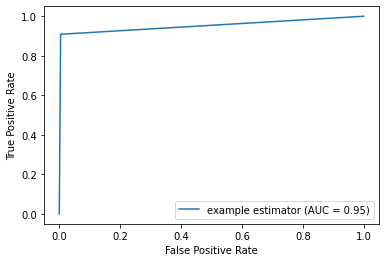

0.9942100558500583
saving model of this epoch as: best_model_roberta-large_0.pth
saving model of this epoch as: last_model_roberta-large_0.pth
Valid Score: 0.8414 Valid Loss: 0.0099 Best Score: 0.8414
Best Score: 0.8414, Time Taken: 732.3614s


In [31]:
model = NBMEModel(config['num_labels'])

tokenizer = get_tokenizer(
    config['model_checkpoint'], precompute=config['precompute_tokens'], df=train, folder=None)

if config['debug']:
    train = train.sample(config['debug']).reset_index(drop=True)

for fold in config['fold_to_train']:
    run(
        model=model,
        df=train, 
        fold=fold,
        tokenizer=tokenizer,
        device=config['device']
    )
    torch.cuda.empty_cache()
    gc.collect()

In [32]:
test = load_and_prepare_test(f"{ROOT}/")
test_df = test.reset_index(drop=True)
test_dataset = NBMETestData(test_df, tokenizer)

In [33]:
print(test_dataset.__dict__['data']['labels'])

0    
1    
2    
3    
4    
Name: labels, dtype: object


  0%|          | 0/3 [00:00<?, ?batch/s]

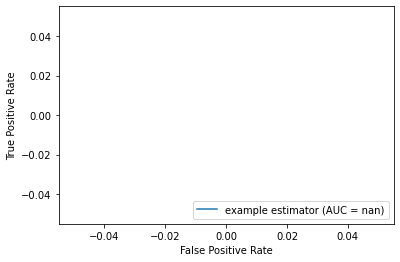

0.9731343283582089
Predictions:  [[(696, 724)], [(663, 665), (668, 693)], [(203, 217)], [(70, 91)], [(222, 258)]]
Loss: 0.0586, Score: 0.0


In [34]:
test_loader = DataLoader(
    test_dataset,
    batch_size=config['train_batch_size'],
    shuffle=False,
    drop_last = False
)
test_loss, test_score, test_predictions = eval_fn(model=model, valid_loader=test_loader, device=device, current_epoch = 0)
print("Predictions: ", test_predictions)
print(f'Loss: {test_loss}, Score: {test_score}')

In [35]:
def load_and_prepare_test_annotated(root=""):
    patient_notes = pd.read_csv(root + "patient_notes.csv")
    features = pd.read_csv(root + "features.csv")
    df = pd.read_csv(root + "15000_unlabelled_data.csv")
    # df = df.merge(features, how="left", on=["case_num", "feature_num"])
    # df = df.merge(patient_notes, how="left", on=['case_num', 'pn_num'])
    
    df['pn_history'] = df['pn_history'].apply(lambda x: x.strip())
    df['feature_text'] = df['feature_text'].apply(process_feature_text)

    df['feature_text'] = df['feature_text'].apply(clean_spaces)
    df['clean_text'] = df['pn_history'].apply(clean_spaces)

    df['labels'] = ""
    print(df)
    return df

In [36]:
test_unannotated = load_and_prepare_test_annotated(f"{ROOT}/")
test_unannotated_df = test_unannotated.reset_index(drop=True)
test_unannotated_dataset = NBMETestData(test_unannotated_df, tokenizer)


        Unnamed: 0  pn_num  case_num                                         pn_history  feature_num                                     feature_text         id                                         clean_text labels
0                0   90000         9  HPI: Ms. Madden is a 20 year old previously he...          900  No relief with Motrin or no relief with tylenol  90000_900  HPI: Ms. Madden is a 20 year old previously he...       
1                1   90000         9  HPI: Ms. Madden is a 20 year old previously he...          901                                          20 year  90000_901  HPI: Ms. Madden is a 20 year old previously he...       
2                2   90000         9  HPI: Ms. Madden is a 20 year old previously he...          902                1 day duration or 2 days duration  90000_902  HPI: Ms. Madden is a 20 year old previously he...       
3                3   90000         9  HPI: Ms. Madden is a 20 year old previously he...          903                        

In [37]:
print(len(test_unannotated_dataset))

150000


In [ ]:
test_unannotated_loader = DataLoader(
    test_unannotated_dataset,
    batch_size=128,
    shuffle=False,
    drop_last = False
)
print(len(test_unannotated_loader))
train_predictions = pred_fn(model=model, test_loader=test_unannotated_loader, device=device)
print("Predictions:", train_predictions)

1172


  0%|          | 0/1172 [00:00<?, ?batch/s]

In [ ]:
import csv
with open('try.csv', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    write.writerow(train_predictions)

In [ ]:
test_unannotated_df['location'] = train_predictions

test_unannotated_df['location'] = test_unannotated_df['location'].replace(r'', float('NaN'), regex = True)
test_unannotated_df.dropna(inplace=True)
test_unannotated_df1 = test_unannotated_df.loc[:, ~test_unannotated_df.columns.str.contains('^Unnamed')]
test_unannotated_df1["id"] = test_unannotated_df1['pn_num'].astype(str) + "_" + test_unannotated_df1['feature_num'].astype(str)
print(test_unannotated_df1.head())
test_unannotated_df1.to_csv("/content/drive/My Drive/CMU/Spring2022/AI_for_Social_Good/Project/Data/train_output.csv")
import spacy
import numpy as np
# def plot_annotation(df, pn_num):
#     options = {"colors": {}}

#     df_text = df[df["pn_num"] == pn_num].reset_index(drop=True)

#     text = df_text["pn_history"][0]
#     ents = []

#     for spans, feature_text, feature_num in df_text[["location", "feature_text", "feature_num"]].values:
#           for s in spans:
#               ents.append({"start": int(s[0]), "end": int(s[1]), "label": feature_text})

#           options["colors"][feature_text] =  f"rgb{tuple(np.random.randint(100, 255, size=3))}"

#     doc = {"text": text, "ents": sorted(ents, key=lambda i: i["start"])}

#     spacy.displacy.render(doc, style="ent", options=options, manual=True, jupyter=True)

# plot_annotation(test_unannotated_df1, test_unannotated_df1['pn_num'][0])

# test_unannotated_df1 = test_unannotated_df1.rename(columns={'Unamed: 0': 'id'})




In [ ]:
df = pd.read_csv("/content/drive/My Drive/train_output.csv")
print(len(df))